In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [2]:
data_train = pd.read_csv("train.csv").fillna(0)
y_train = np.array(pd.read_csv("train.csv")["Transported"].fillna(0).astype(float))
data_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
def enc(x):
    x = np.array(x).reshape(-1, 1).astype(str)
    return pd.DataFrame(OrdinalEncoder().fit_transform(x) + 1).fillna(0)


def transform(data):
    # PassengerId*, HomePlanet(Earth,Europa, Mars), CryoSleep*, Cabin(P or S)*,
    # Destination(TRAPPIST-1e,55 Cancri e, PSO J318.5-22), Age*, VIP*
    data.Age = data.Age / 79
    data.RoomService /= 14327
    data.FoodCourt /= 29813
    data.ShoppingMall /= 23492
    data.Spa /= 22408
    data.VRDeck /= 24133

    data.CryoSleep = (data.CryoSleep.astype(float) == 1.0).astype(int)
    data.VIP = (data.VIP.astype(float) == 1.0).astype(int)
    data[["Deck", "Cabin_num", "Side"]] = data.Cabin.str.split("/", expand=True)
    data.Cabin_num = data.Cabin_num.astype(float) / 1000
    data.Deck = enc(data.Deck)
    data.Side = enc(data.Side)
    data.HomePlanet = enc(data.HomePlanet)
    data.Destination = enc(data.Destination)
    try:
        return data.drop(["PassengerId", "Cabin", "Transported", "Name"], axis=1).fillna(0)
    except KeyError:
        return data.drop(["PassengerId", "Cabin", "Name"], axis=1).fillna(0)



In [4]:
data = transform(data_train.copy())
x_train = np.array(data.values)
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side
0,3.0,0,4.0,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000,1.0
1,2.0,0,4.0,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,6.0,0.000,2.0
2,3.0,0,4.0,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,1.0,0.000,2.0
3,3.0,0,4.0,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,1.0,0.000,2.0
4,2.0,0,4.0,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,6.0,0.001,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,3.0,0,2.0,0.518987,1,0.000000,0.228726,0.000000,0.073322,0.003066,1.0,0.098,1.0
8689,2.0,1,3.0,0.227848,0,0.000000,0.000000,0.000000,0.000000,0.000000,7.0,1.499,2.0
8690,2.0,0,4.0,0.329114,0,0.000000,0.000000,0.079687,0.000045,0.000000,7.0,1.500,2.0
8691,3.0,0,2.0,0.405063,0,0.000000,0.035186,0.000000,0.015753,0.134049,5.0,0.608,2.0


Epoch 1/50
109/109 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.5614 - val_loss: 0.6206 - val_accuracy: 0.7119
Epoch 2/50
109/109 [==============================] - 0s 612us/step - loss: 0.6137 - accuracy: 0.6567 - val_loss: 0.5471 - val_accuracy: 0.7384
Epoch 3/50
109/109 [==============================] - 0s 611us/step - loss: 0.5860 - accuracy: 0.6930 - val_loss: 0.5516 - val_accuracy: 0.7372
Epoch 4/50
109/109 [==============================] - 0s 623us/step - loss: 0.5675 - accuracy: 0.7095 - val_loss: 0.5435 - val_accuracy: 0.7343
Epoch 5/50
109/109 [==============================] - 0s 604us/step - loss: 0.5548 - accuracy: 0.7164 - val_loss: 0.5360 - val_accuracy: 0.7372
Epoch 6/50
109/109 [==============================] - 0s 599us/step - loss: 0.5464 - accuracy: 0.7263 - val_loss: 0.5404 - val_accuracy: 0.7303
Epoch 7/50
109/109 [==============================] - 0s 587us/step - loss: 0.5410 - accuracy: 0.7285 - val_loss: 0.5374 - val_accuracy: 0

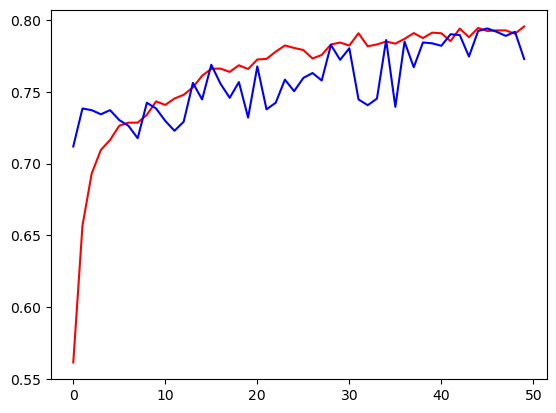

In [11]:
model = tf.keras.Sequential([
    Input((13,)),
    Dense(40, "relu"),
    Dropout(0.2),
    Dense(8, "relu"),
    Dropout(0.2),
    Dense(1, "sigmoid")
])
model.compile("adam", tf.losses.binary_crossentropy, ["accuracy"])
his = model.fit(x_train, y_train, 64, epochs=50, validation_split=0.2).history
model.evaluate(x_train, y_train)
plt.plot(his["accuracy"], c="r")
plt.plot(his["val_accuracy"], c="b")
plt.show()


740
745
750
755
0.8004600345025877


(740, 10)

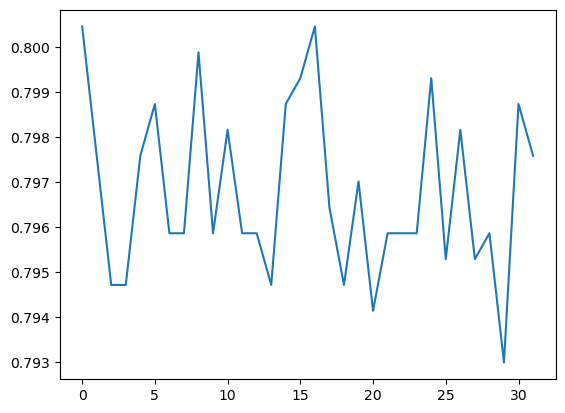

In [7]:
x_tr, x_test, y_tr, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
print(x_tr.shape, y_tr.shape, x_test.shape, y_test.shape)

a = []
clfs = []
for i in range(740, 760, 5):
    for j in range(10,50, 5):
        clf = RandomForestClassifier(n_estimators=i, max_depth=j)
        clf.fit(x_tr, y_tr)
        a.append(clf.score(x_test, y_test))
        clfs.append(clf)
    print(i)
plt.plot(a)
clf_rf = max(clfs, key=lambda x: x.score(x_test, y_test))
print(clf_rf.score(x_test, y_test))
d = clf_rf.get_params(deep=True)
d['n_estimators'], d['max_depth']

0.7964347326049454

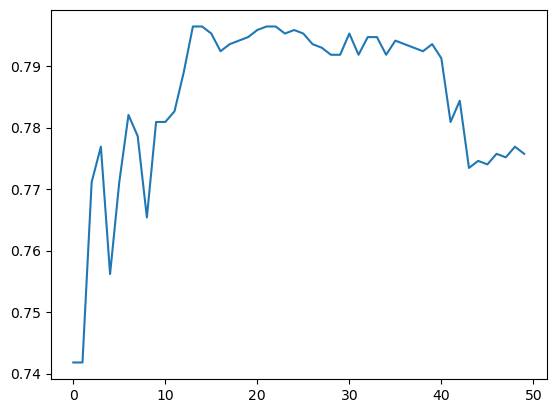

In [8]:
a = []
clfs = []
for i in range(1, 100, 2):
    clf = AdaBoostClassifier(n_estimators=i)
    clf.fit(x_tr, y_tr)
    a.append(clf.score(x_test, y_test))
    clfs.append(clf)
plt.plot(a)
clf_ada = max(clfs, key=lambda x: x.score(x_test, y_test))
clf_ada.score(x_test, y_test)

In [9]:
test = pd.read_csv("test.csv").fillna(0)
test = transform(test.copy())
x_test = np.array(data.values)

In [12]:
sub = pd.read_csv("sample_submission").fillna(0)

sub.Transported = pd.DataFrame((model.predict(x_test) > 0.5)).astype(bool)
pd.DataFrame(sub[["PassengerId", "Transported"]]).to_csv("resultNN.csv", index=False)

# sub.Transported = pd.DataFrame((clf_rf.predict(x_test)).astype(int)).astype(bool)
# pd.DataFrame(sub[["PassengerId", "Transported"]]).to_csv("result RandomForest.csv", index=False)
#
# sub.Transported = pd.DataFrame((clf_rf.predict(x_test)).astype(int)).astype(bool)
# pd.DataFrame(sub[["PassengerId", "Transported"]]).to_csv("result Ada.csv", index=False)

272/272 [==============================] - 0s 286us/step
